In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm.auto import tqdm

from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

jet = cm.get_cmap('jet')

/tmp/ipykernel_93854/1764591451.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


In [2]:
Y = (torch.rand(size=(5,12)) > 0.5).float()
Y = torch.unique(Y, dim=-1)
Y = Y.repeat_interleave(torch.randint(2, 7, size=(Y.shape[-1],)), dim=1)

In [14]:
torch.unique(Y.T, dim=0, return_inverse=True)

(tensor([[0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 1.],
         [0., 1., 1., 0., 1.],
         [0., 1., 1., 1., 1.],
         [1., 0., 0., 0., 1.],
         [1., 0., 0., 1., 1.],
         [1., 0., 1., 1., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 0., 1., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1.]]),
 tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
          8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11]))

In [12]:
minterms.shape

torch.Size([12, 5])

$Y$ is rank-4 but has 9 minterms. Assume that we could have 4 linear classifiers $W\in\mathbb{R}^{4\times d}$
$$
\begin{bmatrix}
1 & 0 & 0 & 1 & 0 & 1 & 1\\
0 & 1 & 0 & 1 & 1 & 0 & 1\\
0 & 0 & 1 & 0 & 1 & 1 & 1\\
\end{bmatrix}
$$

# Optimization for some chosen Y (no l2 normalization)

In [38]:
#Y = (torch.rand(size=(5,12)) > 0.5).float()
#Y = torch.unique(Y, dim=-1)
#Y = Y.repeat_interleave(torch.randint(2, 7, size=(Y.shape[-1],)), dim=1)

u, labels = torch.unique(Y, dim=-1, return_inverse=True)
labels = labels / labels.max()

c, n = Y.shape

X = torch.normal(0, 0.01, size=(n, 8), requires_grad=True)
norm = torch.ones(size=(n,), requires_grad=True)

alpha = 0.9
beta  = 0.9
tau = 1.0
niter = 600
device = "cpu"

optimizer = optim.Adam([X, norm], lr=0.02)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

tracker = {'loss' : [], 'x_svals' : []}
bar = tqdm(total=niter, dynamic_ncols=True, desc='Train')

X = X.to(device)
Y = Y.to(device)
norm = norm.to(device)

for i in range(niter):
    optimizer.zero_grad()

    #K = norm.reshape(-1,1) * torch.exp(-(torch.cdist(X, X, p=2)**2) / tau) * norm.reshape(1,-1)

    K = X @ X.T
    z_svals = torch.sqrt(F.relu(torch.real(torch.linalg.eigvals(Y.T @ Y + K))))
    x_svals = torch.sqrt(F.relu(torch.real(torch.linalg.eigvals(K))))
    z_nuc = z_svals.sum()
    x_nuc = x_svals.sum()

    loss = z_nuc - alpha * x_nuc + beta * x_svals.max() ** 2

    loss.backward()
    tracker['loss'].append(loss.detach().item())
    tracker['x_svals'].append(x_svals.detach().sort()[0])
    optimizer.step()
    scheduler.step()
    bar.set_postfix(loss="{:1.5e}".format(loss.detach().item()),
                    tau="f{:1.3e}".format(tau),
                    lr="{:1.3e}".format(scheduler.optimizer.param_groups[0]['lr']))
    bar.update()
bar.close()

Train:   0%|          | 0/600 [00:00<?, ?it/s]

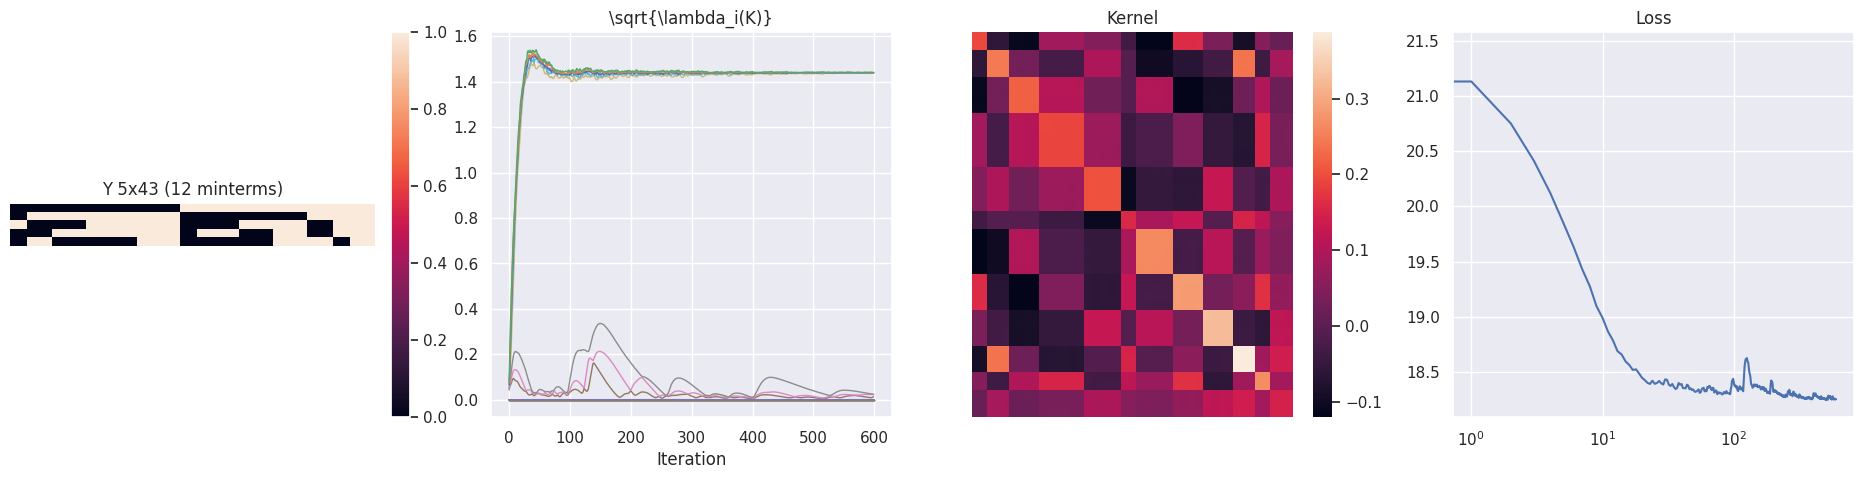

In [39]:
Y_ = Y.detach().cpu()
X_ = X.detach().cpu().T
K_ = K.detach().cpu()
svals_ = torch.stack(tracker['x_svals'], dim=0).detach().cpu()
Z_ = torch.cat((Y_,X_), dim=0)

fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.imshow(Y_)
plt.axis("off")
plt.title(f"Y {Y_.shape[0]}x{Y_.shape[1]} ({u.shape[1]} minterms)")
plt.subplot(1,5,2)
for j in range(svals_.shape[1]):
    plt.plot(svals_[:,j], '-', linewidth=1.0)
plt.title("\sqrt{\lambda_i(K)}")
plt.xlabel("Iteration")
plt.subplot(1,5,3)
sns.heatmap(K_)
plt.colorbar(fraction=0.05, pad=0.04)
plt.axis("off")
plt.title("Kernel")
plt.subplot(1,5,4)
plt.plot(tracker["loss"])
plt.xscale("log")
plt.title("Loss")
plt.show()

In [174]:
torch.real(torch.linalg.eig(K)[0])

tensor([ 1.6623e+00,  1.7012e+00,  1.7046e+00,  1.7048e+00,  1.7069e+00,
         1.7087e+00,  1.7091e+00,  1.7093e+00,  1.2879e-04,  4.3327e-05,
         3.9453e-05,  3.6080e-05,  3.4039e-05,  1.7725e-05,  2.3682e-05,
         2.1647e-05,  2.0834e-05,  1.3706e-05,  6.3703e-06,  5.2020e-06,
         3.6912e-06,  4.0830e-06,  4.3198e-06,  2.9532e-06,  2.0405e-06,
         2.1546e-06,  1.8780e-06,  1.5963e-06,  1.4790e-06, -5.2348e-08,
         4.6911e-08,  2.4279e-08,  7.7591e-07,  5.8577e-07,  4.4260e-07,
         5.0105e-07], grad_fn=<SelectBackward0>)

In [148]:
torch.diag(Y)

tensor([1.0206e+00, 1.7719e-01, 1.5115e-01, 1.1240e-01, 3.3057e-08, 1.9964e-08,
        1.0423e-08, 4.4477e-09, 2.7820e-09, 1.1373e-09, 2.4959e-10, 3.5343e-16,
        1.9653e-16, 4.2334e-17, 1.0551e-17, 1.9564e-23, 2.8078e-24, 1.7117e-26,
        5.5936e-32])

In [121]:
X_.shape

torch.Size([8, 20])

In [141]:
F.normalize(X_, dim=0, p=2)[:,0] @ F.normalize(X_, dim=0, p=2)[:,1]

tensor(0.9999)

In [142]:
Y[:,:5]

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])

In [67]:
torch.sqrt(F.relu(torch.real(torch.linalg.eigvals(Y.T @ Y + K)))).sort(descending=True)[0][:16]

tensor([8.7404e+00, 4.1493e+00, 3.7853e+00, 3.1256e+00, 3.0408e+00, 2.3480e+00,
        6.8822e-02, 3.4110e-02, 1.6685e-02, 1.2362e-02, 1.0733e-02, 9.4290e-03,
        8.8685e-03, 7.6996e-03, 7.3039e-03, 6.1921e-03],
       grad_fn=<SliceBackward0>)

In [85]:
torch.sqrt(F.relu(torch.real(torch.linalg.eigvals(K)))).sort(descending=True)[0]

tensor([1.4976e+00, 1.4971e+00, 1.4970e+00, 1.4961e+00, 1.4959e+00, 1.4955e+00,
        1.4950e+00, 1.4943e+00, 1.4942e+00, 1.4939e+00, 1.4936e+00, 1.4929e+00,
        1.4923e+00, 1.4903e+00, 1.4902e+00, 1.4871e+00, 3.4392e-04, 1.0145e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<SortBackward0>)

In [204]:
from scipy import optimize

mu = torch.linalg.svdvals(Y)
print(mu)
def curve(x):
    x = x[0]
    return [np.array([x / np.sqrt(m**2 + x**2) for m in mu]).sum() - len(mu)*alpha + 2.0 * beta * x]

def grad(x):
    x = x[0]
    return [np.array([m**2 / np.sqrt(m**2 + x**2)**3 for m in mu]).sum() + 2.0 * beta]

sol = optimize.root(curve, [0.0], jac=grad, method='hybr')
print("Singular values according to theory: {}".format(round(sol.x[0], 5)))

tensor([7.3598, 4.1473, 3.0502, 2.3812, 1.9129])
Singular values according to theory: 1.3859


In [207]:
svals_[-1].sort()[0]

tensor([1.2387e-04, 2.2150e-04, 2.9942e-04, 4.7550e-04, 4.7550e-04, 6.0516e-04,
        7.4308e-04, 7.9280e-04, 8.5641e-04, 9.3035e-04, 1.0902e-03, 1.1188e-03,
        1.3195e-03, 1.4543e-03, 1.6787e-03, 2.0117e-03, 2.0117e-03, 2.1570e-03,
        2.4879e-03, 2.7341e-03, 3.1481e-03, 3.3183e-03, 3.5155e-03, 3.7133e-03,
        3.7254e-03, 4.0071e-03, 4.1204e-03, 4.4604e-03, 5.0771e-03, 5.4155e-03,
        5.7825e-03, 6.3847e-03, 7.2328e-03, 8.8298e-03, 1.3541e-02, 1.3080e+00,
        1.3128e+00, 1.3138e+00, 1.3154e+00, 1.3159e+00, 1.3163e+00, 1.3163e+00,
        1.3165e+00, 1.3167e+00])

<StemContainer object of 3 artists>

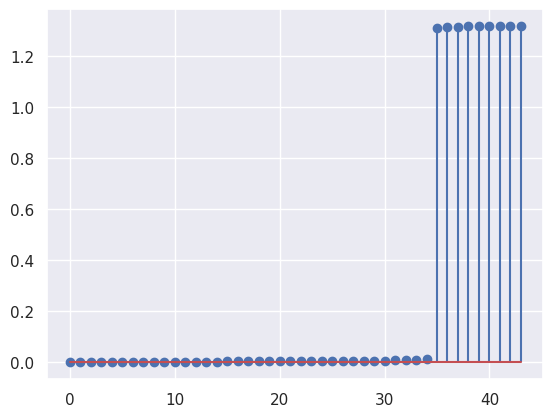

In [206]:
plt.figure()
plt.stem(svals_[-1])